Functions

In [4]:
import pandas as pd
import numpy as np
import umap
import numpy as np
import sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import umap.plot
import GEOparse
from sklearn.decomposition import PCA
import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")

In [36]:
######################################################
def pca_analysis(df, n_comp=None):
    #1. Calculate PCA Dataframe and Agg statistics
    pca_df = df.copy()
    pca_df = pca_df.dropna().reset_index(drop=True)

    #create data object based on full df
    data_df = pca_df.drop(['cell_id', 'zone'], axis=1).copy()    
    data_df = data_df.astype(float)
    cols    = data_df.columns
    x       = data_df.loc[:, ].values #make sure only data columns are being passed

    #normalizes data to z scores
    x = StandardScaler().fit_transform(x)
    scaled_df = pd.DataFrame(data = x, columns = cols)

    pca = PCA(n_components = n_comp)
    principalComponents = pca.fit_transform(x) #Xnew

    # print(f'check variance with pca.explained_variance: \n{np.cov(principalComponents.T)}')
    print(f'pca.explained_variance: \t{pca.explained_variance_}')
    print(f'pca.explained_variance_ratio: \t{pca.explained_variance_ratio_}')

    #adjust pc_cols
    pc_cols = ['PC' + str(f+1) for f in range(n_comp)]
    # print(pc_cols)
    
    #creates dataframe from pca results
    principalDf = pd.DataFrame(data = principalComponents
                , columns = pc_cols)

    #df of pca analysis and potential clustering categories
    finalDf = pd.concat([principalDf, df[['cell_id', 'zone']]], axis = 1) # add additional cluster categories here
    
    return finalDf
######################################################
def plot_pca(df, n_comp=None):
    pca_df = df.copy()
    if n_comp == 3:
        ## Basic Plot ##
        # create a 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])

        # add labels to the plot
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
            # show the plot
        plt.show()

        # create a plotly figure
        fig = go.Figure()

        # add a 3D scatter plot
        fig.add_trace(go.Scatter3d(
            x=pca_df['PC1'], y=pca_df['PC2'], z=pca_df['PC3'],
            mode='markers',
            marker=dict(
                size=5,
                color=pca_df['PC3'],
                colorscale='Viridis',
                opacity=0.8
            )
        ))

        # add axes labels and title
        fig.update_layout(
            scene=dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3',
                aspectmode='cube',
            ),
            title='3D PCA Plot'
        )

        # show the figure
        fig.show()
    elif n_comp == 2: 
        # create 2 d scatter plot of pca
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='zone')
        plt.show()
######################################################
def load_rnaseq():
    # load table B
    rnaseq = pd.read_csv("./table_B_scRNAseq_UMI_counts.tsv", sep='\t')
    #sort top ~7531 genes
    rnaseq['total'] = rnaseq.sum(axis=1)

    rnaseq = rnaseq[rnaseq['total'] > 80].reset_index(drop=True) 
    # approximates the top genes from the paper, 
    # potentially need to review STAR methods and adjust how this is done
    rnaseq = rnaseq.reset_index(drop=True).set_index('gene')
    rnaseq = rnaseq.drop(columns='total') #UMI is number of observed transcripts
    rnaseq = rnaseq.transpose().reset_index().rename({'index':'cell_id'}, axis=1)

    #add location data based on cells
    loc_df = pd.read_csv("./table_C_scRNAseq_tsne_coordinates_zones.tsv", sep='\t')

    rnaseq = pd.merge(rnaseq, loc_df[['cell_id', 'zone']], on='cell_id')
    rnaseq
    return rnaseq
######################################################
def apply_umap(df=None):
    rnaseq = load_rnaseq()

    data_df = rnaseq.drop(['cell_id', 'zone'], axis=1).reset_index(drop=True)
    data_df = data_df.astype(float)

    # dists = [0.1, 0.2, 0.3, 0.5]
    # neighbors = [15, 25, 50, 75, 100]
    # for min_dist in dists:
    #     for n_neighbors in neighbors:
    #build model
    reducer = umap.UMAP()
    scaler  = sklearn.preprocessing.StandardScaler()
    data    = scaler.fit_transform(data_df)

    #UMAP
    embedding        = reducer.fit(data)
    rnaseq_coord_df  = pd.DataFrame(embedding.embedding_, columns=['X','Y'])
    rnaseq['X']      = rnaseq_coord_df['X']
    rnaseq['Y']      = rnaseq_coord_df['Y']
    rnaseq['total']  = data_df.sum(axis=1)

    #create projeciton with location data
    umap.plot.points(embedding, labels=rnaseq['zone'])
    plt.title(f'UMAP of Top {rnaseq.shape[1]} Genes Colored by Location Data')
    plt.show()
    return rnaseq
######################################################

# Step 1: Recreate Previous Work

### PCA 2 Components

pca.explained_variance: 	[1053.61490409  267.88465929]
pca.explained_variance_ratio: 	[0.14008157 0.03561615]


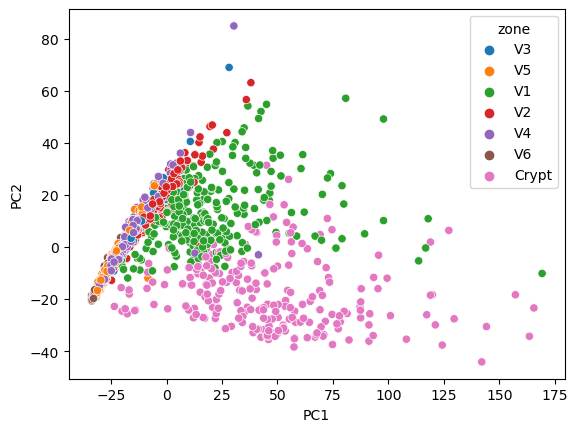

In [5]:
n_comp  = 2
rnaseq = load_rnaseq()

finalDf = pca_analysis(rnaseq, n_comp=n_comp)

# finalDf = finalDf[finalDf['PC1'] < 100].reset_index(drop=True) #removal of outliers?

plot_pca(finalDf, n_comp=n_comp)

# fdoes data need to be log transformed? 

In [6]:
rnaseq

#[']

,cell_id,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Vcpip1,Snhg6,...,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7,PISD,DHRSX,zone
0,AAACCTGGTAAGTTCC,0,1,1,0,0,0,0,0,0,...,4,1,57,4,0,87,0,0,1,V3
1,AAACGGGCACCAACCG,0,2,0,0,0,1,0,1,0,...,5,2,81,4,0,104,0,0,0,V5
2,AAACGGGTCACTGGGC,0,2,2,0,0,0,0,0,0,...,3,1,32,1,0,116,0,1,2,V1
3,AAAGATGGTGGACGAT,0,4,0,0,1,0,0,0,0,...,4,3,61,3,0,118,0,0,0,V2
4,AAAGATGGTTCGGGCT,2,1,1,0,0,1,0,0,0,...,6,3,71,9,0,138,0,1,0,V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,TTTATGCGTTGAGGTG,0,1,1,1,0,0,1,0,1,...,13,7,60,10,0,164,2,1,0,V1
1379,TTTCCTCTCCCGACTT,0,0,0,0,0,0,0,0,0,...,2,2,27,2,1,44,0,2,0,V5
1380,TTTGCGCTCAAGATCC,0,1,0,0,1,1,0,0,0,...,3,2,21,2,0,34,0,0,0,V5
1381,TTTGGTTCAAAGCAAT,0,0,0,0,0,0,0,0,0,...,7,4,120,4,1,200,2,1,0,V4


PCA 3 Components

In [ ]:
#table b
n_comp  = 3
rnaseq = load_rnaseq()

finalDf = pca_analysis(rnaseq, n_comp=n_comp)
finalDf = finalDf[finalDf['PC1'] < 100].reset_index(drop=True) #removal of outliers
plot_pca(finalDf, n_comp=n_comp)

Format Data and Apply ParTI.m Program

In [78]:
# need to transpose CSC_raw_seurat_data
# edit exampleCancer.m to use this and CSC_genes file



tSNE

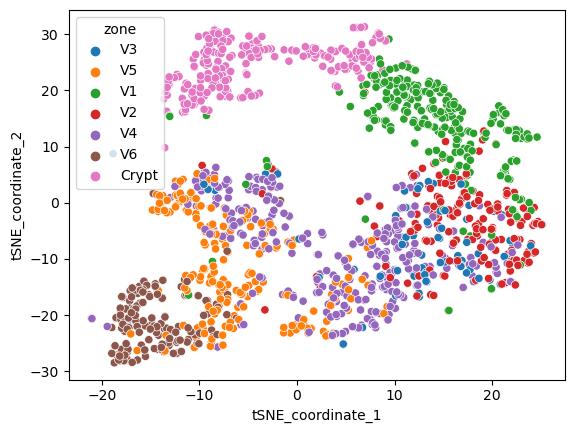

In [195]:
import seaborn as sns
tsne_df = pd.read_csv('./table_C_scRNAseq_tsne_coordinates_zones.tsv', sep='\t')

sns.scatterplot(data=tsne_df, x='tSNE_coordinate_1', y='tSNE_coordinate_2', hue='zone')

# redetermine 

plt.show()
#needs more elegant plot, with "zone" column added as color hue
#What other filters could be interesting for this?? 

# Step 2: Apply UMAP and compare to previous Results

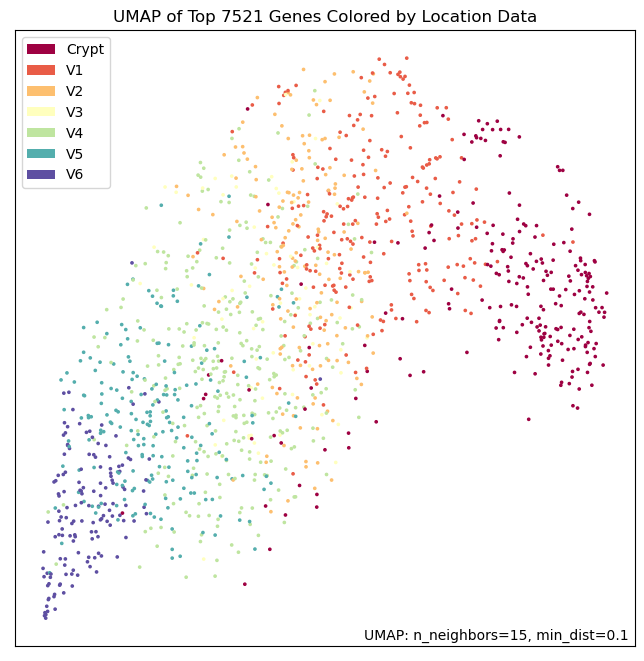

In [52]:
#Run this cell to generate the dataset
umap_coordinates = apply_umap()

## How does this method differ from PCA, and what are the advantages

In [60]:
umap_coordinates[umap_coordinates.total == 29626]

,cell_id,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Vcpip1,Snhg6,...,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7,PISD,DHRSX,zone,X,Y,total
974,CCTCTGACATATACCG,2,5,2,0,2,0,3,0,0,...,10,0,208,0,3,4,V1,-1.211497,5.088814,29626.0


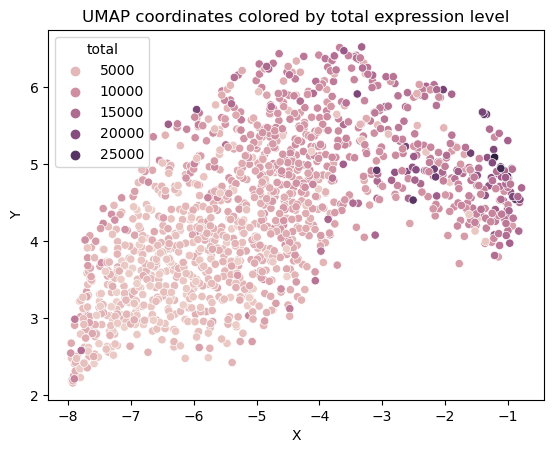

In [53]:
#compare total gene expression on the plot
genes = ['total']
for gene in genes: 
    sns.scatterplot(data=umap_coordinates, x='X', y='Y', hue=gene)
    plt.title(f'UMAP coordinates colored by {gene} expression level')
    plt.show()

# Pick genes and view expression level

In [54]:
umap_coordinates
genes = umap_coordinates.columns
genes = genes.drop(['cell_id', 'zone', 'X', 'Y', 'total']) #keeps track of non gene columns
print([f for f in genes])


['Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1', 'Pcmtd1', 'Rrs1', 'Vcpip1', 'Snhg6', 'Cops5', 'Cspp1', 'Arfgef1', 'Ncoa2', 'Tram1', 'Lactb2', 'Xkr9', 'Terf1', 'Rpl7', 'Rdh10', 'Ube2w', 'Tceb1', 'Tmem70', 'Ly96', 'Mcm3', 'Smap1', 'Sdhaf4', 'Fam135a', 'Lmbrd1', 'Phf3', 'Ptp4a1', 'Zfp451', 'Dst', 'Ccdc115', 'Imp4', 'Ptpn18', 'Fam168b', 'Plekhb2', 'Hs6st1', 'Uggt1', 'Neurl3', 'Kansl3', 'Lman2l', 'Cnnm4', 'Cox5b', 'Actr1b', 'Tmem131', 'Inpp4a', 'Coa5', 'Unc50', 'Mgat4a', '2010300C02Rik', 'Mitd1', 'Mrpl30', 'Txndc9', 'Eif5b', 'Pdcl3', 'Npas2', 'Rpl31', 'Cnot11', 'Rnf149', 'Map4k4', 'Slc9a2', 'Mfsd9', 'Mrps9', 'Fhl2', 'Nck2', 'Uxs1', 'Tpp2', 'Tex30', 'Slc40a1', 'Stat1', 'Gls', 'Nab1', 'Mfsd6', 'Inpp1', 'Hibch', 'Ormdl1', 'Osgepl1', 'Asnsd1', 'Stk17b', 'Gtf3c3', 'Pgap1', 'Sf3b1', 'Coq10b', 'Hspd1', 'Hspe1', 'Mob4', '9430016H08Rik', 'Spats2l', 'Bzw1', 'Clk1', 'Ppil3', 'Nif3l1', 'Fam126b', 'Ndufb3', 'Cflar', 'Casp8', 'Trak2', 'Stradb', 'Sumo1', 'Nop58', 'Bmpr2', 'Fam117b', 'Wdr12', 'Nbeal1', 

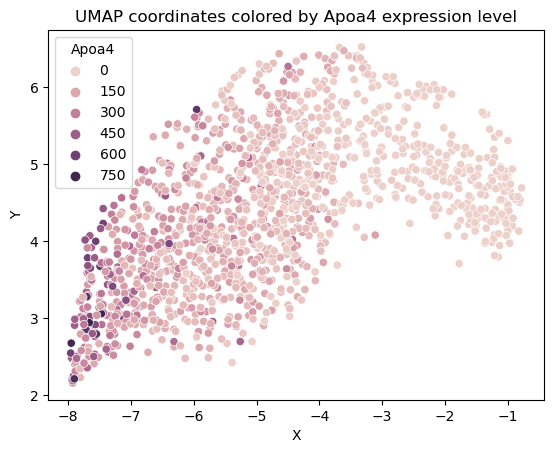

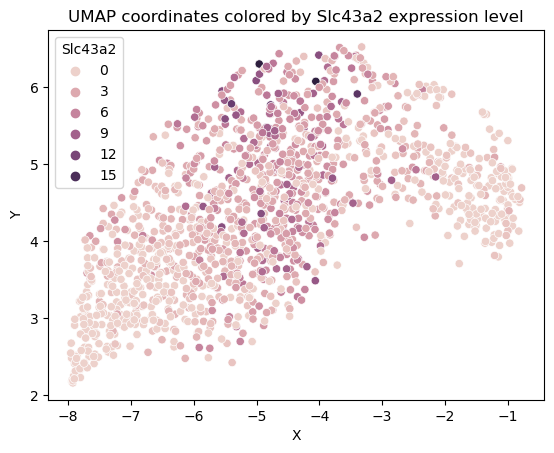

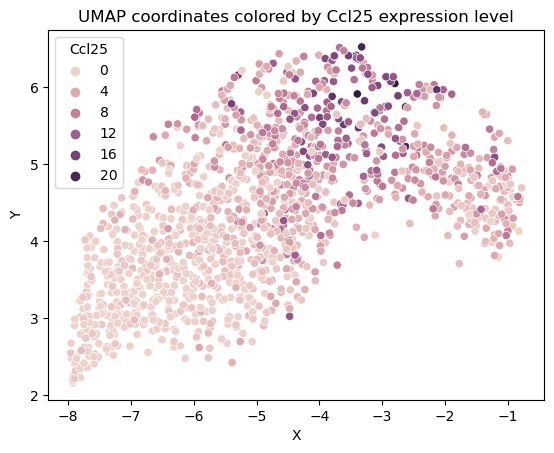

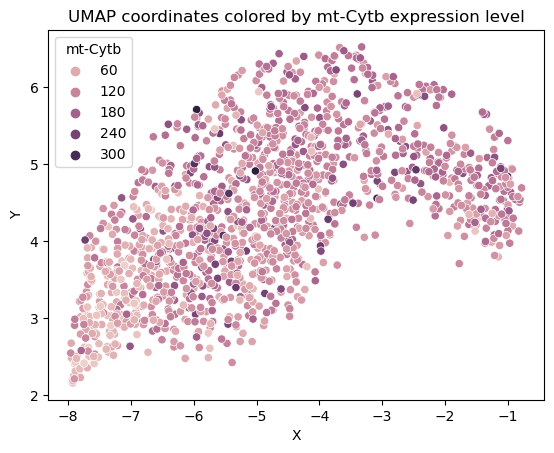

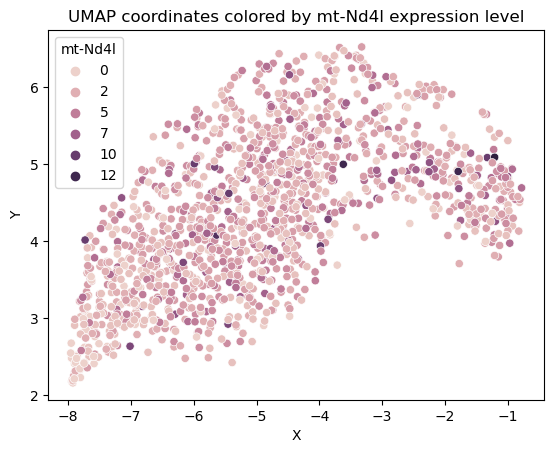

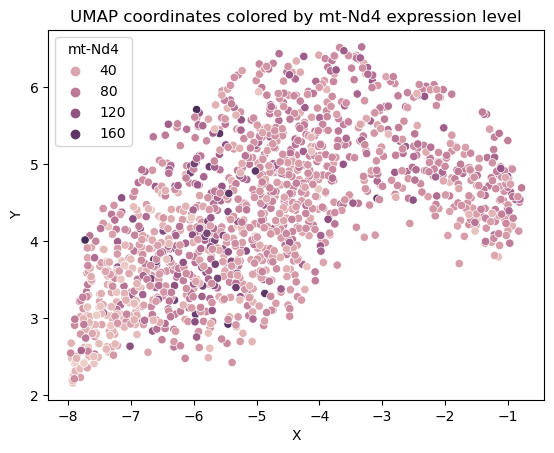

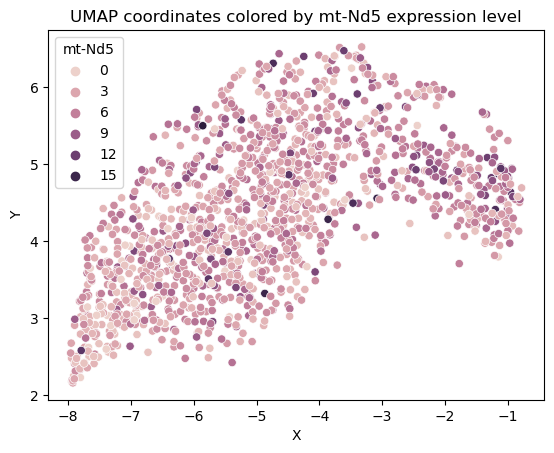

In [61]:
genes_subset = ['Apoa4','Slc43a2','Ccl25', 'mt-Cytb', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5'] #pick genes from list above

for gene in genes_subset: 
    sns.scatterplot(data=umap_coordinates, x='X', y='Y', hue=gene)
    plt.title(f'UMAP coordinates colored by {gene} expression level')
    plt.show()

# Step 3: (If time) Apply to a different dataset, apply ParetoTI to UMAP results 

In [56]:
# on pause
# import GEOparse
# gse = GEOparse.get_GEO(geo="GDS4382", destdir='./new_data/')

# df_gse = gse.table
# non_control = df_gse[df_gse['IDENTIFIER'] != '--Control']
# #determine overlap of genes with previous dataset
# df_gse

# import pandas as pd
# data = pd.DataFrame(gse.table['VALUE'].T, index=gse.table['ID_REF'], columns=gse.table.columns[2:])
# data
# df_geo = gse.table
# display(df_geo)